## Задача
1. Проверьте повысилось ли качество на стандартных подходах при лемматизации/и без неё
2. Удалите/(замените на тег) из текстов сущности(имена, локации, что-то ещё). Запустите классификатор и модельки на сеточках
3. Сделайте выводы


In [96]:
# !wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
# !unzip imdb.zip
# !pip -q install eli5
# !pip -q install spacy
# !python -m spacy download en

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [97]:
!head train.tsv

/bin/bash: /home/ekaterina/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)












In [98]:
# train_pos_path = 'aclImdb_v1/aclImdb/train/pos'
# train_neg_path = 'aclImdb_v1/aclImdb/train/neg'
# test_pos_path ='aclImdb_v1/aclImdb/test/pos'
# test_neg_path ='aclImdb_v1/aclImdb/test/neg'

In [99]:
# df_train = []
# for path in [train_pos_path, train_neg_path]:
#     for filename in os.scandir(path):
#         if path[-1] == 's':
#             if filename.is_file():
#                 name, ext = os.path.splitext(filename.path)
#                 if ext == ".txt":
#                   with(open(filename.path,"r",encoding='utf-8') as f):
#                     text = f.read()
#                     tokens = text.split()

#                   label = 0
#                   df.append((text, label))
#         else:
#             if filename.is_file():
#                 name, ext = os.path.splitext(filename.path)
#                 if ext == ".txt":
#                   with(open(filename.path,"r",encoding='utf-8') as f):
#                     text = f.read()
#                     tokens = text.split()

#                   label = 1
#                   df.append((text, label))            

In [100]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


In [101]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'excellent','sensational','brilliant','awsome','love', 'great', 'best', 'wonderful', 'interesting', 'funny', 'amazing', 'magnificent', 'splendid', 'gorgeous', 'beautiful', 'happy', 'fantastic', 'fabulous', 'perfect' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap', 'bad', 'worse', 'less', 'talentless', 'mediocre', 'worthless', 'unhappy'  #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))

Test accuracy = 71.15%


In [102]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

In [103]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

In [104]:
train_df.head()

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...


### Замена NER
Заменим именованные сущности на их тэги, чтобы модель не обучалась на расличных названиях сущностей

In [139]:
# !python -m spacy download ru_core_news_lg

In [140]:
# !pip install corus razdel navec slovnet deeppavlov

In [105]:
import nltk
import spacy
from spacy import displacy
import en_core_web_md
import ru_core_news_lg

import corus
from corus import load_ne5
from razdel import tokenize

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, GRU, LSTM, Dropout, Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn import model_selection, preprocessing, linear_model

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /home/ekaterina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ekaterina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/ekaterina/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/ekaterina/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [134]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

Заменим найденные сущности на их тэги

In [126]:
doc =nlp(train_df['review'][0])
for ent in doc.ents:
    print(ent.text, ent.label_)
displacy.render(doc, style='ent', jupyter=True)

Dreamgirls ORG
Tony PERSON
an incredibly weak year DATE
Broadway FAC
First ORDINAL
One CARDINAL
Effie ORG
Jennifer Hudson PERSON
Jamie Foxx's PERSON
Beyonce Knowles PERSON
Anika Noni Rose PERSON
third ORDINAL
Dreamgirls ORG
Eddie Murphy PERSON
James Brown PERSON
American Idol ORG
Jennifer Hudson PERSON
Effie ORG
Effie ORG
Effie ORG
Effie ORG
Effie ORG
Effie ORG
Hudson PERSON
Effie ORG
Hudson PERSON
Effie ORG
Hudson PERSON
Foxx ORG
Hudson ORG
Foxx ORG


In [256]:
# функция для замены ner в тексте на тэги
def ner_to_text(text, nlp):
    doc = nlp(text)
    for ent in doc.ents:
        text = text.replace(ent.text, ent.label_)
    return text

In [136]:
train_df['review_ner'] = train_df['review'].apply(lambda row: ner_to_text(row, nlp))

In [137]:
train_df.head()

,is_positive,review,review_ner
0,0,"Dreamgirls, despite its fistful of Tony wins i...","ORG, despite its fistful of PERSON wins in DAT..."
1,0,This show comes up with interesting locations ...,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...,"I simply love this movie. I also love the ORG,..."
3,0,Spoilers ahead if you want to call them that.....,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...,My all-time favorite movie! I have seen many m...


In [138]:
test_df['review_ner'] = test_df['review'].apply(lambda row: ner_to_text(row, nlp))

### Лемматизация и удаление стоп-слов

In [141]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [142]:
sw = set(get_stop_words("en"))
sw_left = set(['no','not', 'nor', "mustn't", "shouldn't","shan't", 'against', "aren't", "can't",
 'cannot',"wouldn't",
 "couldn't","didn't", "doesn't", "don't", "hadn't", "hasn't","haven't", "isn't", "wasn't", "weren't", "won't"
              ])
sw_in = set(['im', 'u', 'will', 'just'])

In [143]:
sw.symmetric_difference_update(sw_left)

In [144]:
sw.update(sw_in)

In [145]:
puncts = set(punctuation)

In [146]:
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
#     txt = re.sub("no\s", "not", 'nore', txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    for word in txt:
        if '@' in word:
            txt.remove(word)
    return " ".join(txt)

In [147]:
from tqdm import tqdm 
tqdm.pandas()

train_df['review_ner'] = train_df['review_ner'].progress_apply(preprocess_text)
test_df['review_ner'] = test_df['review_ner'].progress_apply(preprocess_text)

100%|██████████| 25000/25000 [00:31<00:00, 781.33it/s]


In [148]:
train_df.head()

,is_positive,review,review_ner
0,0,"Dreamgirls, despite its fistful of Tony wins i...",org despite fistful person wins date fac never...
1,0,This show comes up with interesting locations ...,show comes interesting locations fast travel c...
2,1,I simply love this movie. I also love the Ramo...,simply love movie also love org sorta biased b...
3,0,Spoilers ahead if you want to call them that.....,spoilers ahead want call almost recommend film...
4,1,My all-time favorite movie! I have seen many m...,alltime favorite movie seen many movies one be...


In [149]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [150]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review_ner'].values)

CountVectorizer()

Посмотрим на слова, попавшие в словарь:

In [151]:
vectorizer.get_feature_names()

['0000000000001',
 '00000cardinalcardinal0',
 '00015',
 '007',
 '0080',
 '0083',
 '00cardinal0',
 '00s',
 '01',
 '010',
 '01000',
 '0110',
 '012310',
 '02',
 '0310',
 '041',
 '05',
 '050',
 '0510',
 '053105',
 '06',
 '089',
 '08th',
 '09',
 '09082009',
 '0cardinal',
 '0cardinal0',
 '0cardinaloctcardinal009',
 '0s',
 '0stars',
 '10',
 '100',
 '1000',
 '10000',
 '100000date',
 '1000s',
 '1001',
 '100am',
 '101',
 '1010',
 '1010seek',
 '101575',
 '102',
 '1035',
 '10cardinal',
 '10cardinal0',
 '10master',
 '10min',
 '10money000',
 '10of',
 '10s',
 '10star',
 '10the',
 '10this',
 '10x10',
 '11',
 '110',
 '1100',
 '1100th',
 '110jd',
 '1110',
 '111128',
 '111232',
 '111but',
 '112',
 '112101',
 '112413',
 '112443',
 '1131516',
 '11cardinal',
 '11m',
 '11th',
 '12',
 '1200',
 '12007',
 '1201',
 '121cardinal',
 '123',
 '1245am',
 '12638',
 '12a',
 '12m',
 '12s',
 '12th',
 '12thrateat',
 '13',
 '1300s',
 '1314',
 '1335',
 '1335is',
 '1336th',
 '13but',
 '13cardinal',
 '13money',
 '13th',
 '14'

Попробуем кого-нибудь таки сконвертировать

In [152]:
vectorizer.transform([train_df['review_ner'].iloc[3]])

<1x85226 sparse matrix of type '<class 'numpy.int64'>'
	with 153 stored elements in Compressed Sparse Row format>

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Получилось что надо.

Запустим теперь её на реальных данных.

In [154]:
model.fit(train_df['review_ner'], train_df['is_positive'])

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [155]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review_ner'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.83%


Получается в результате замены именованных сущностей на их тэги, лемматизации и удаления стоп-слов accuracy увеличилась с 86.5% до 86.83%

In [156]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+1.827,refreshing
+1.791,wonderfully
+1.539,hooked
+1.496,delightful
+1.372,flawless
+1.356,rare
+1.345,funniest
+1.321,surprisingly
+1.306,excellent
+1.285,perfect


Посмотрим на конкретные примеры его работы:

In [157]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review_ner'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [158]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review_ner'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Посмотрим на примеры неправильной классификации, наконец:

In [159]:
import numpy as np

preds = model.predict(test_df['review_ner'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review_ner'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_ner'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.46%


Тут также accuracy немного выше варианта без замены ner, лемматизации и исключения стоп-слов (88.28% было, 88.46% стало)

### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [161]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_ner'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.70%


### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [162]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_ner'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.52%


In [163]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review_ner'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [164]:
train_df['review_ner']

0        org despite fistful person wins date fac never...
1        show comes interesting locations fast travel c...
2        simply love movie also love org sorta biased b...
3        spoilers ahead want call almost recommend film...
4        alltime favorite movie seen many movies one be...
                               ...                        
24995    big fan movie not usual reasons think person o...
24996    not going bother plot synopsis since know movi...
24997    movie dont know take indellible character pers...
24998    saw film dvd date gobsmacked flabbergasted una...
24999    disappointment none nuance original norp seem ...
Name: review_ner, Length: 25000, dtype: object

<BarContainer object of 246 artists>

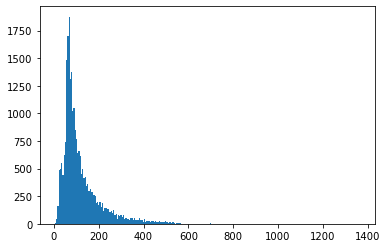

In [165]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review_ner.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [166]:
from collections import Counter

words_counter = Counter((word for text in train_df.review_ner for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 15441


**Задание** Сконвертируйте данные

In [167]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review_ner, word2idx, 1000)
X_test = convert(test_df.review_ner, word2idx, 1000)

/tmp/ipykernel_4137/2083256968.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
/tmp/ipykernel_4137/2083256968.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [212]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [213]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [245]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 64)          988224    
                                                                 
 global_max_pooling1d_3 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 990849 (3.78 MB)
Trainable params: 990849 (3.78 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [246]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=3, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/3
196/196 [==============================] - 8s 37ms/step - loss: 0.5648 - accuracy: 0.7368 - val_loss: 0.3461 - val_accuracy: 0.8580
Epoch 2/3
196/196 [==============================] - 7s 35ms/step - loss: 0.2682 - accuracy: 0.8930 - val_loss: 0.2933 - val_accuracy: 0.8758
Epoch 3/3
196/196 [==============================] - 7s 36ms/step - loss: 0.1778 - accuracy: 0.9360 - val_loss: 0.2998 - val_accuracy: 0.8776


**Задание** Подсчитайте качество модели на тесте

In [247]:
test_pred_proba = model.predict(X_test)

782/782 [==============================] - 1s 2ms/step


In [248]:
test_pred = test_pred_proba.round()

In [249]:
from sklearn.metrics import classification_report

In [250]:
# отчет по метрикам
def get_classification_report(y_test_true, y_test_pred):
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))

In [251]:
get_classification_report(test_df.is_positive, test_pred)

TEST

              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12500
           1       0.87      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [252]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_precision_recall_curve, precision_recall_curve, recall_score, plot_roc_curve

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])


    plt.show()

/tmp/ipykernel_4137/1996997817.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))


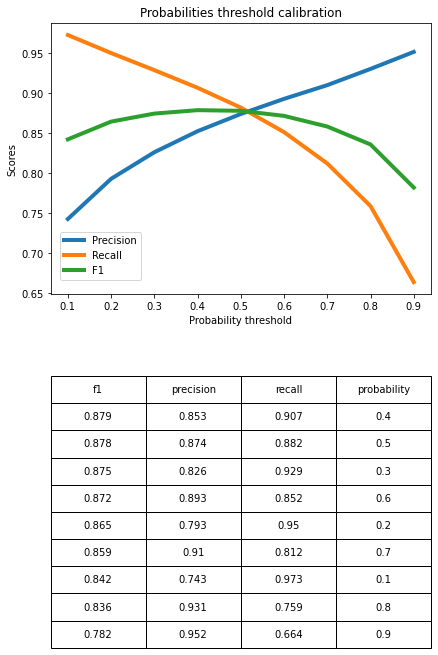

In [253]:
show_proba_calibration_plots(test_pred_proba, test_df.is_positive)

In [254]:
test_pred= np.where(test_pred_proba.round(2)>0.5, 1, 0)
test_pred

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [255]:
get_classification_report(test_df.is_positive, test_pred)

TEST

              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



В результате преобразований и использования нейросети удалось добиться повышения accuracy, f1 меры. Они составляют 0.88. Но логистическая регрессия, обученная на tf_idf векторах дает accuracy 0.8846. Для данной задачи линейная модель рааботает не хуже нейросети.